In [146]:
# utf-8
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium

import os
import json

plt.rcParams["figure.figsize"] = [18,12]

First read a data file with fixed parameters

In [128]:
swiss_uni_grant = pd.read_csv("Data/P3_GrantExport.csv", sep=";", quotechar="\"", quoting=0)

In [90]:
swiss_uni_grant.head()

,"﻿""Project Number""",Project Title,Project Title English,Responsible Applicant,Funding Instrument,Funding Instrument Hierarchy,Institution,University,Discipline Number,Discipline Name,Discipline Name Hierarchy,Start Date,End Date,Approved Amount,Keywords
0,1,Schlussband (Bd. VI) der Jacob Burckhardt-Biog...,NaN,Kaegi Werner,Project funding (Div. I-III),Project funding,NaN,Nicht zuteilbar - NA,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,11619.00,NaN
1,4,Batterie de tests à l'usage des enseignants po...,NaN,Massarenti Léonard,Project funding (Div. I-III),Project funding,Faculté de Psychologie et des Sciences de l'Ed...,Université de Genève - GE,10104,Educational science and Pedagogy,"Human and Social Sciences;Psychology, educatio...",01.10.1975,30.09.1976,41022.00,NaN
2,5,"Kritische Erstausgabe der ""Evidentiae contra D...",NaN,Kommission für das Corpus philosophorum medii ...,Project funding (Div. I-III),Project funding,Kommission für das Corpus philosophorum medii ...,"NPO (Biblioth., Museen, Verwalt.) - NPO",10101,Philosophy,Human and Social Sciences;Linguistics and lite...,01.03.1976,28.02.1985,79732.00,NaN
3,6,Katalog der datierten Handschriften in der Sch...,NaN,Burckhardt Max,Project funding (Div. I-III),Project funding,Abt. Handschriften und Alte Drucke Bibliothek ...,Universität Basel - BS,10302,Swiss history,Human and Social Sciences;Theology & religious...,01.10.1975,30.09.1976,52627.00,NaN
4,7,Wissenschaftliche Mitarbeit am Thesaurus Lingu...,NaN,Schweiz. Thesauruskommission,Project funding (Div. I-III),Project funding,Schweiz. Thesauruskommission,"NPO (Biblioth., Museen, Verwalt.) - NPO",10303,Ancient history and Classical studies,Human and Social Sciences;Theology & religious...,01.01.1976,30.04.1978,120042.00,NaN


Replace all non numerical values with 0

In [131]:
swiss_uni_grant[swiss_uni_grant['Approved Amount']=='data not included in P3']=0

We also need to convert all values to floats

In [132]:
swiss_uni_grant['Approved Amount'] =  swiss_uni_grant['Approved Amount'].apply(lambda x: pd.to_numeric(x, errors='ignore'))

Now we can group all grants by University. University name we will use further to identify the canton

In [136]:
swiss_uni_grant_grouped = swiss_uni_grant.groupby(["University"])['Approved Amount'].sum().reset_index()

Let's check. Apparently there are some wrong values

In [140]:
swiss_uni_grant_grouped.head()

,University,Approved Amount
0,0,0.0
1,AO Research Institute - AORI,3435621.0
2,Allergie- und Asthmaforschung - SIAF,19169965.0
3,Berner Fachhochschule - BFH,31028695.0
4,Biotechnologie Institut Thurgau - BITG,2492535.0


Remove them

In [141]:
swiss_uni_grant_grouped.drop([0],axis=0, inplace=True)

Let's have a first overview how money flows into different universities

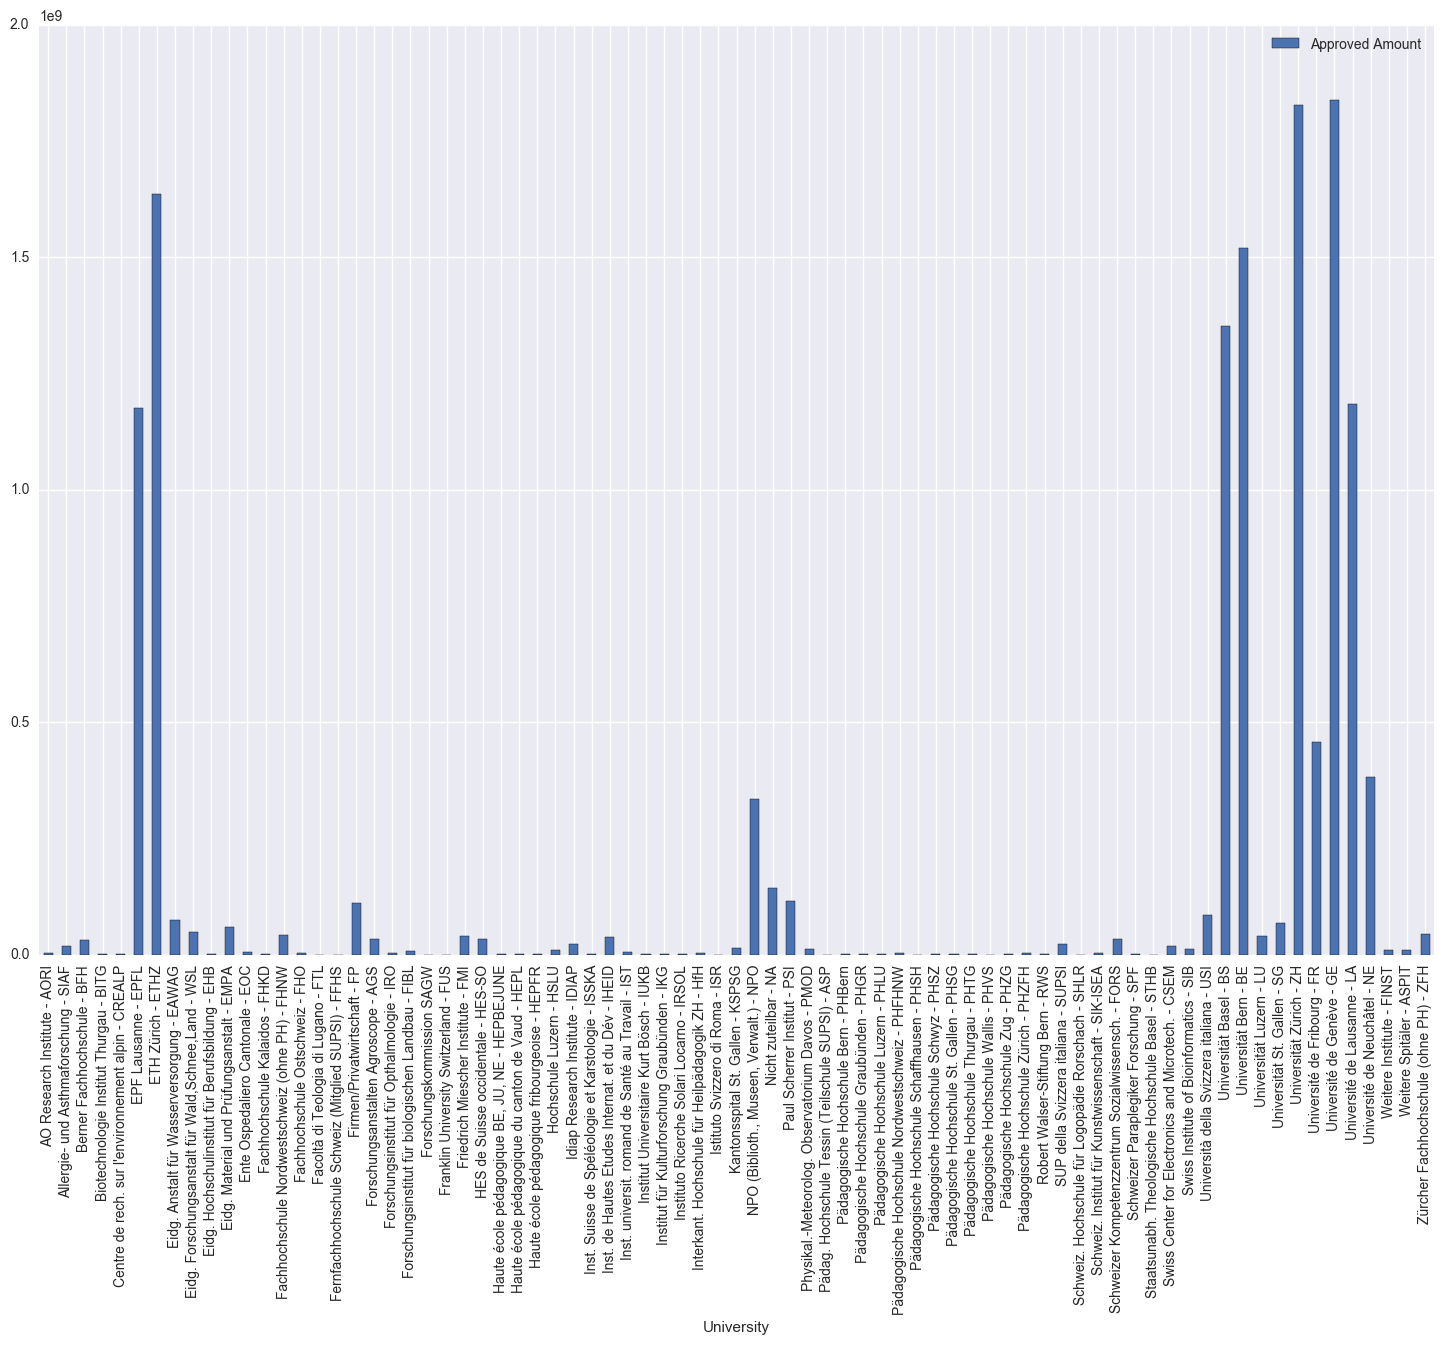

In [147]:
swiss_uni_grant_grouped.plot(kind='bar', x=swiss_uni_grant_grouped['University'])

Now we need to inroduce a new variable for cantons and try to find a map between cantons and universities

In [166]:
swiss_uni_grant_grouped['Canton'] = ''

In [ ]:
# Vasilii could you check how this part works on your side? If it is not good, please see the another library 
# in the next cell

import requests
url = 'https://maps.googleapis.com/maps/api/geocode/json'

for uni in swiss_uni_grant_grouped.University:
    params = {'sensor': 'false', 'address': uni}
    r = requests.get(url, params=params)
    results = r.json()['results']
    if results:
        try:
            canton = results[0]['address_components'][4]['short_name']
        except:
            canton = 'N/A'
#         swiss_uni_grant_grouped[swiss_uni_grant_grouped.University==uni]['Canton'] = canton
        swiss_uni_grant_grouped.loc[swiss_uni_grant_grouped.University == uni, 'Canton'] = canton

In [ ]:
# https://pypi.python.org/pypi/geopy/1.11.0
# It did not work with an Airport WiFi
# You can try first ArcGIS and OpenMapQuest as both of them open source

from geopy.geocoders import Nominatim, Bing, ArcGIS, YahooPlaceFinder, IGNFrance, OpenMapQuest
geolocator = OpenMapQuest()
location = geolocator.geocode("EPF Lausanne - EPFL")
print(location)


Now we can start to work on the visualisation part. First we need to read the data

In [78]:
swiss_cantons = os.path.join('Data/', 'ch-cantons.topojson.json')
geo_json_data = json.load(open(swiss_cantons,encoding='utf-8'))

And prepare a Swiss map, to do so we provide the cooridnates of the geographical centre in Switzerland

In [79]:
swiss_map = folium.Map(location=[46.4754, 8.1355],
                   tiles='Mapbox Bright', zoom_start=8)

Now we can build a choropleth map of swiss grants per canton

In [104]:
swiss_map.choropleth(geo_str=geo_json_data, key_on='cantons.id', fill_color='YlGn')

In [105]:
swiss_map